In [1]:
# Install Prophet
# !pip install prophet


In [2]:
# Import Dependencies 
import sqlite3
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

In [ ]:
# Connect to space_data database
conn = sqlite3.connect('')

OperationalError: unable to open database file

In [ ]:
# Load missions table
missions_df = pd.read_sql_query('SELECT * FROM missions;', conn)
missions_df['date'] = pd.to_datetime(missions_df['date'], errors='coerce')
missions_df['year'] = missions_df['date'].dt.year


In [ ]:
# Count missions per year
missions_per_year = missions_df.groupby('year').size().reset_index(name='missions')


In [ ]:
# Prepare for Prophet
# prophet_df = missions_per_year.rename(columns={'year': 'ds', 'missions': 'y'})
# prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], format='%Y')

In [ ]:
# Use only data from 2000 onward to focus on modern launch trends
filtered_df = missions_per_year[missions_per_year['year'] >= 2000]
prophet_df = filtered_df.rename(columns={"year": "ds", "missions": "y"})
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], format='%Y')

In [ ]:
# Build and fit model
model = Prophet(
    yearly_seasonality = True,
    changepoint_range = 0.8,             # Focus changepoints on recent data
    changepoint_prior_scale = 0.5        # Allow more flexibility in the trend
)
model.fit(prophet_df)

20:47:59 - cmdstanpy - INFO - Chain [1] start processing
20:47:59 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# Forecast through 2050
future = model.make_future_dataframe(periods=2050 - prophet_df['ds'].dt.year.max(), freq='YE')
forecast = model.predict(future)

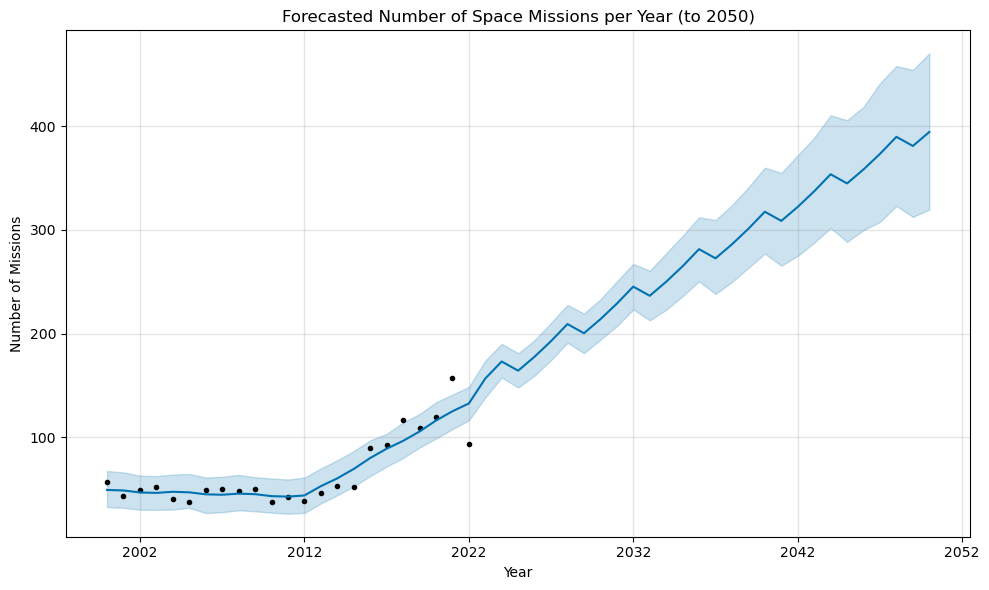

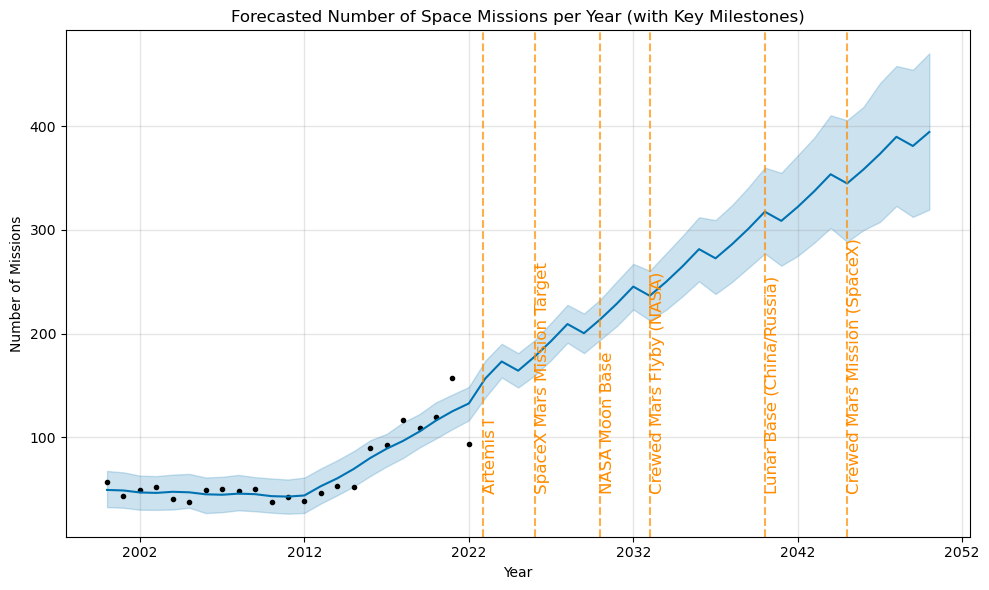

In [ ]:
# Plot results
model.plot(forecast)
plt.title("Forecasted Number of Space Missions per Year (to 2050)")
plt.xlabel("Year")
plt.ylabel("Number of Missions")
plt.tight_layout()
plt.show()

fig = model.plot(forecast)

# Add vertical lines for major milestones
milestones = {
    'Artemis I': '2022-11-16',
    'SpaceX Mars Mission Target': '2026-01-01',
    'NASA Moon Base': '2030-01-01',
    'Crewed Mars Flyby (NASA)': '2033-01-01',
    'Lunar Base (China/Russia)': '2040-01-01',
    'Crewed Mars Mission (SpaceX)': '2045-01-01'
}

for name, date in milestones.items():
    date = pd.to_datetime(date)
    plt.axvline(date, color='darkorange', linestyle='--', alpha=0.7)
    plt.text(
        date,
        forecast['yhat'].min() * 1.05,  # Lower placement
        name,
        rotation=90,
        color='darkorange',
        fontsize=12,
        ha='left',
        va='bottom'
    )
plt.title('Forecasted Number of Space Missions per Year (with Key Milestones)')
plt.xlabel('Year')
plt.ylabel('Number of Missions')
plt.tight_layout()
plt.show()

In [ ]:
# Showing forecast data
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
41,2040-12-31,308.684555,265.399493,354.979574
42,2041-12-31,322.203686,274.875944,371.918490
43,2042-12-31,337.200494,287.516104,388.913112
44,2043-12-31,353.664386,301.808044,410.526210
45,2044-12-31,344.817973,288.448349,405.801671
46,2045-12-31,358.337104,299.776164,418.683865
47,2046-12-31,373.333912,307.652549,441.527475
48,2047-12-31,389.797805,323.025752,458.126070
49,2048-12-31,380.951392,312.541768,454.422935
50,2049-12-31,394.470522,319.579064,470.334550
